# CS986 Classification Problem
## CS986FoMLDAGroup2
- Aravinthkumar Pattaiyan - 202367339
- Liyi Tan - 202383002
- Blaise Marvin Rusoke - 202354498
- Shrishti Sridhar Manja - 202362138
- Hrutuja Mangesh Patkar - 202389142

## 1.0 Introduction
The task at hand is a multiclass classification problem, which involves building a machine learning model to predict the genre of a song based on its musical attributes, such as the tempo, loudness, energy,  and danceability. Prior to training a machine learning classifier, we extensively carried out data exploration and feature preprocessing so as to generate assumptions about the dataset and also ensure optimal model performance.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,VotingClassifier,StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

## 2.0 Data Overview:

The dataset comprises song attributes such as title, artist, year, tempo, energy, danceability, loudness, and more. Each entry represents a unique track with its associated genre. 

### 2.1 Read data into memory

In [2]:
training_df = pd.read_csv('data/CS98XClassificationTrain.csv')
test_df = pd.read_csv('data/CS98XClassificationTest.csv')

In [3]:
training_df.shape

(453, 15)

### 2.2 Investigating the structure of the data using a few columns

In [4]:
training_df.head()

,Id,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre
0,1,My Happiness,Connie Francis,1996,107,31,45,-8,13,28,150,75,3,44,adult standards
1,2,Unchained Melody,The Teddy Bears,2011,114,44,53,-8,13,47,139,49,3,37,NaN
2,3,How Deep Is Your Love,Bee Gees,1979,105,36,63,-9,13,67,245,11,3,77,adult standards
3,4,Woman in Love,Barbra Streisand,1980,170,28,47,-16,13,33,232,25,3,67,adult standards
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,1973,121,47,56,-8,15,40,193,45,3,63,glam rock


## 3.0 Data Preprocessing

### 3.1 Handling Null and Duplicate Values
The dataset was initially inspected for any null values.

In [5]:
training_df.isna().any()

Id           False
title        False
artist       False
year         False
bpm          False
nrgy         False
dnce         False
dB           False
live         False
val          False
dur          False
acous        False
spch         False
pop          False
top genre     True
dtype: bool

The target 'top genre' column was found to contain null values. Initially, these were inspected to see if the top genres could be inferred from the other columns such as artist name and song title. But eventually, these null values were dropped because we could not infer song genre from any of the other attributes.

In [6]:
training_df = training_df.dropna(subset=['top genre'])

The dataset was then inspected for any duplicated values - The Id column was dropped first since it is possible to have records with duplicated features but with different Ids.

In [7]:
# drop the Id column first, since it doesn't help that much when distinguishing the uniqueness of values
training_df = training_df.drop(columns=['Id'])

In [8]:
training_df[training_df.duplicated()]

,title,artist,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top genre
46,Take Good Care Of My Baby - 1990 Remastered,Bobby Vee,2011,82,43,49,-12,12,66,151,70,6,60,adult standards


Only one duplicated record was found. So we then drop it because it doesn't introduce any new information for our model to learn and it could be a potential source of data leakage when testing our model.

In [9]:
training_df = training_df.drop_duplicates()

### 3.2 Categorical Feature Exploration
Using the normalized mutual information score metric, the contribution of each of the different categorical variables to the overall variance in the genre types was investigated.

In [10]:
categorical_types = list(training_df.dtypes[training_df.dtypes=='object'].index)

In [11]:
categorical_types.append('year')

In [12]:
for t in categorical_types:
    if t != 'top genre':
        print(f'{t}: {training_df[t].nunique()} unique values')
        print(f"Normalized Mutual Information Score: {normalized_mutual_info_score(training_df[t],training_df['top genre'])}")
        print('\n')

title: 436 unique values
Normalized Mutual Information Score: 0.7147514018263358


artist: 331 unique values
Normalized Mutual Information Score: 0.7483175926593625


year: 64 unique values
Normalized Mutual Information Score: 0.4863258751606623




From the obtained results, the artist categorical variable contributed most to the observed variance in the top genre target variable. This was followed by the title variable and then subsequently by the year variable.

#### 3.2.1 Label Encoding
To convert the categorical target 'top genre' variable into a numerical format comprising of unique integer values, the Label encoding transformer was used.

In [13]:
le = LabelEncoder()
le.fit(training_df['top genre']);

#### 3.2.2  Data Partitioning
The data was then divided into the features and targets.

In [14]:
X = training_df.drop(columns=['top genre'])
Y = training_df['top genre']

#### 3.2.3 Feature Selection
From our observations and after different iterations of testing the final models' performance, the performance was better with some of the data columns dropped from the dataset. So these were removed as illustrated below. This process helps streamline the dataset, reducing noise and focusing the model on the most informative attributes for accurate predictions.

In [15]:
del X['title']
del X['spch']

In [16]:
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size=0.1,random_state=42)

In [17]:
y_train = le.transform(y_train)

In [18]:
y_val = le.transform(y_val)

### 3.3 Assumptions
Our objective prior to selecting and using any machine learning models was to generate some assumptions about the structure of the data, which would then guide our model selection and evaluation process. We initially visualized the distribution of all numerical attributes in the dataset, and thereafter the interaction between the majority genre types in the dataset and the numerical attributes. This feature-target attribute interaction is ultimately what guided our model selection process.

In [19]:
numerical_columns = list(training_df.dtypes[training_df.dtypes != 'object'].index.values)

<Figure size 1000x800 with 0 Axes>

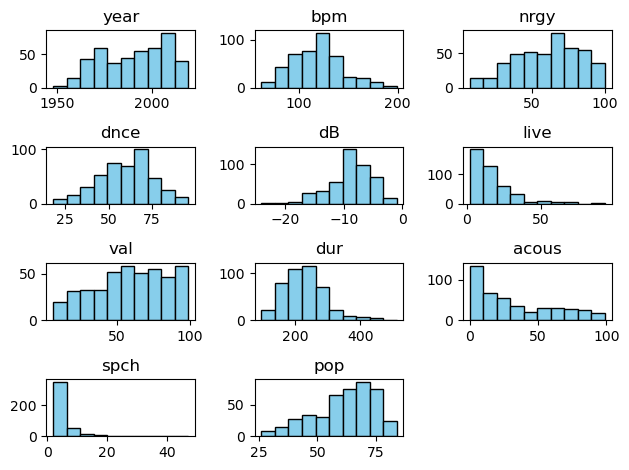

In [20]:
plt.figure(figsize=(10, 8))
training_df.loc[:, numerical_columns].hist(grid=False, edgecolor='black', color='skyblue')
plt.tight_layout()
plt.show()

In [21]:
training_df2 = training_df.copy()

In [22]:
numerical_columns.append('top genre')

In [23]:
# for visualization purposes, creating a subset of the original dataframe containing only the genre types with the highest 
# frequency
viz_train_df = training_df2[training_df2['top genre'].isin(['adult standards','album rock','dance pop','brill building pop',
                                                           'glam rock'])]

The pairsplot provided a comprehensive visualization of how the majority genre classes interact with the numerical features. It revealed the intricate relationships among different classes, indicating the complexity of the dataset. The absence of discernible linear relationships led us to rule out linear models like Logistic Regression. Instead, decision tree classifiers and tree ensembles were chosen due to their capacity to capture nonlinear patterns and interactions within the data more effectively.

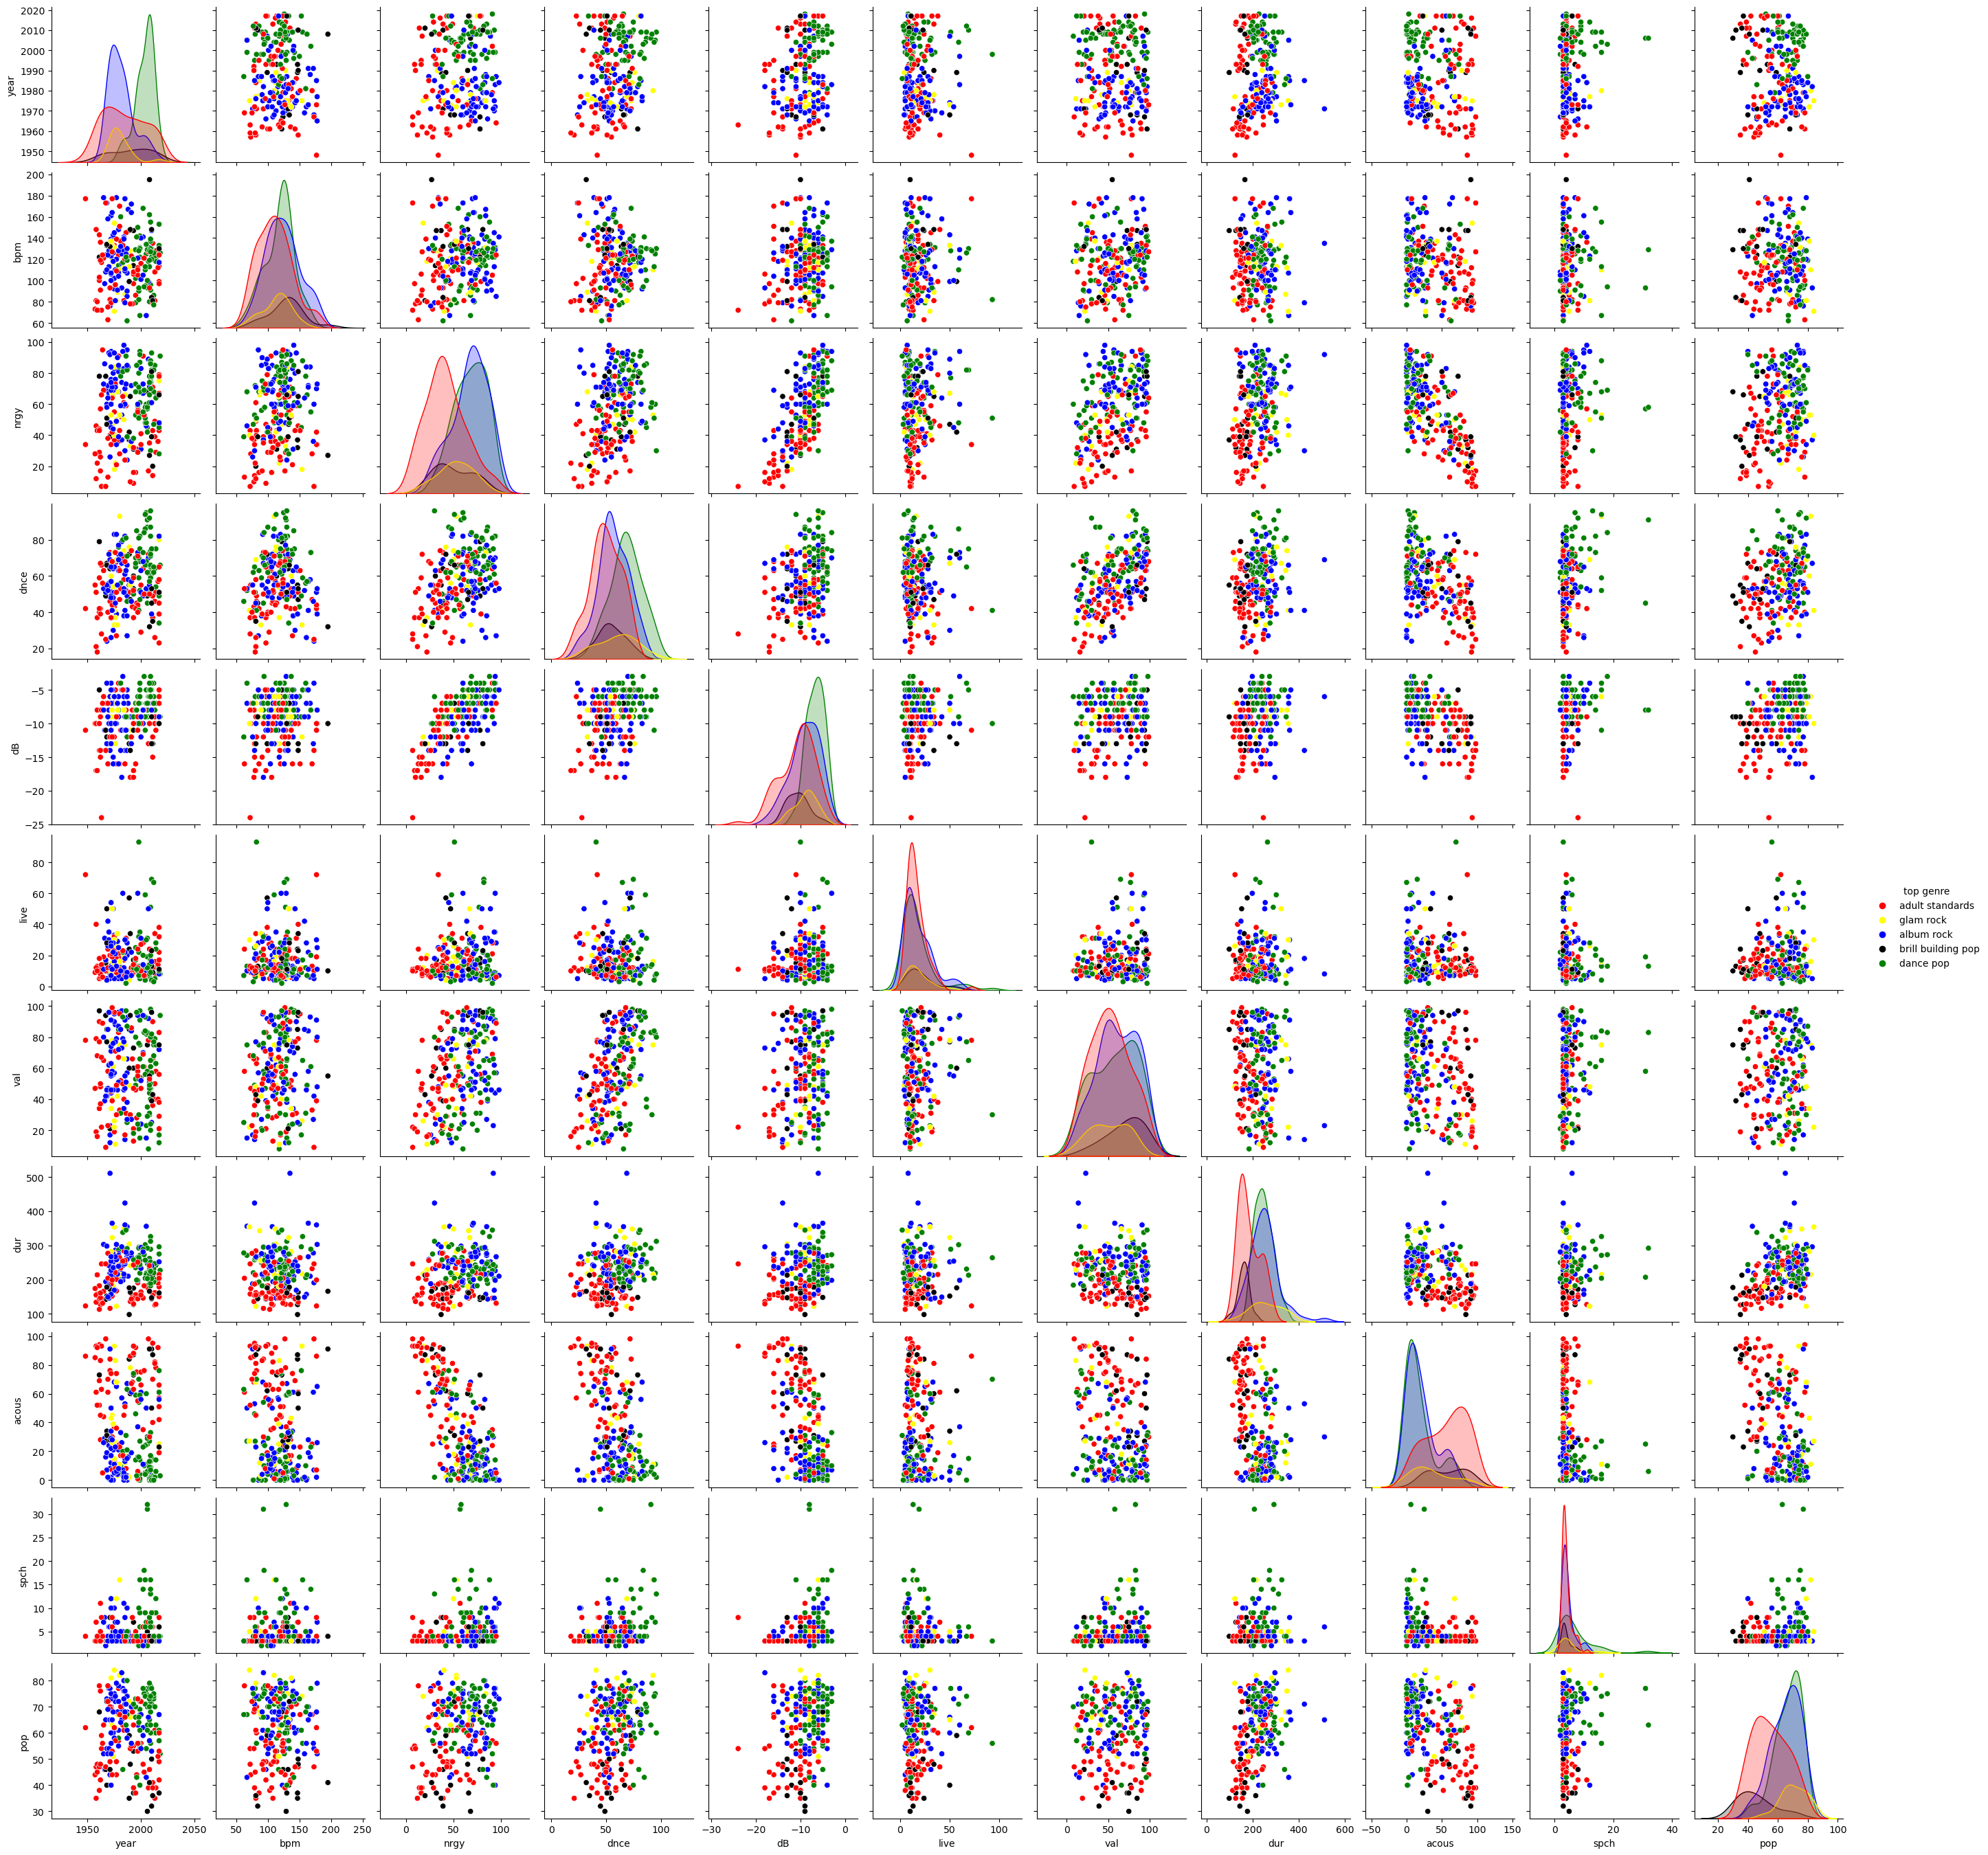

In [24]:
custom_palette = {'adult standards': 'red', 'album rock': 'blue', 'dance pop': 'green','brill building pop':'black',
                  'glam rock':'yellow'}

sns.pairplot(viz_train_df.loc[:,numerical_columns],hue='top genre',palette=custom_palette)

### 3.4 One Hot Encoding
A preprocessing pipeline and transformer was built to encode the categorical variables using onehotencoding. This preprocessing pipeline will encode the 'artist' and 'year' columns using one-hot encoding, while leaving other columns unchanged ('passthrough'). This setup is useful when handling a mix of categorical and numerical features in a dataset.

In [25]:
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
preprocessing = ColumnTransformer([
    ('cat',cat_pipeline,['artist','year'])
],remainder="passthrough")

In [26]:
x_train = preprocessing.fit_transform(x_train)

In [27]:
x_val = preprocessing.transform(x_val)

## 4.0 Model Selection and Hyperparameter Tuning
For the baseline model, a Decision Tree Classifier was chosen due to its ability to handle non-linear relationships and interactions in the data, aligning with the dataset's complexity. Grid search technique was utilized to identify optimal hyperparameters prior to model training. This approach ensures that the model is tuned effectively for optimal performance on the dataset.

### 4.1 Decision Tree Classifier
The GridSearch process explored various combinations of max_depth and min_samples_leaf hyperparameters of the Decision Tree Classifier. A cross validation fold of 3 and an accuracy scoring metric were used to extract the model's optimal hyperparamters for the dataset.

In [28]:
params = {
    'max_depth':[2,4,6,8,10,12],
    'min_samples_leaf':[1,2,4,6,8,10,12]
}

In [29]:
gridsearch_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1),
    param_grid=params,
    scoring='accuracy',
    verbose=5,
    cv=3,
    n_jobs=8
)

In [30]:
gridsearch_dt.fit(x_train,y_train);
gridsearch_dt.best_params_

Fitting 3 folds for each of 42 candidates, totalling 126 fits


C:\ProgramData\anaconda\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'max_depth': 6, 'min_samples_leaf': 1}

In [31]:
dt2 = DecisionTreeClassifier(max_depth=6,min_samples_leaf=1).fit(x_train,y_train)

**4.1.1 Model Accuracy on our validation set: 0.318**

In [32]:
y_pred = dt2.predict(x_val)
accuracy_score(y_val,y_pred)

0.3181818181818182

**4.1.2 Model Accuracy on our training set: 0.458**

In [33]:
y_train_pred = dt2.predict(x_train)
accuracy_score(y_train,y_train_pred)

0.4580152671755725

### 4.2 Random Forest Classifier

**Random Forest Classifier** **(Our Final Chosen Model)**: Building upon the promising performance observed with decision tree classifiers, we opted for an ensemble approach using Random Forest Classifiers. This model aggregates multiple decision trees to make predictions, offering improved robustness and generalization. Similar to our previous approach, we employed GridSearch to identify the optimal hyperparameters, ensuring the Random Forest Classifier is finely-tuned for optimal performance on our dataset.

In [34]:
params = {
    'max_depth':[4,6,8,10,12,14,16,18],
    'min_samples_leaf':[1,2,4,6,8,10,12],
    'n_estimators':[50,100,200,400,600,800]
}

In [35]:
gridsearch_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1),
    param_grid=params,
    scoring='accuracy',
    verbose=0,
    cv=3,
    n_jobs=-1
)
# gridsearch_rf.fit(x_train,y_train);
# gridsearch_rf.best_params_

The gridsearch exploration generated a max depth of 16, min samples leaf of 1 and 200 estimators as the optimal model hyperparameters. It is now commented out because of the time it takes to run. The final RandomForestClassifier model was then trained on these optimal hyperparameters values.

In [36]:
rfx2 = RandomForestClassifier(max_depth=16,min_samples_leaf=1,n_estimators=200,random_state=1).fit(x_train,y_train)

**4.2.1 Model Accuracy on our validation set: 0.4318181818181818**

In [37]:
y_pred = rfx2.predict(x_val)
accuracy_score(y_val,y_pred)

0.4318181818181818

**4.2.2 Model accuracy on the training set: 0.9287531806615776**

In [38]:
y_train_pred = rfx2.predict(x_train)
accuracy_score(y_train,y_train_pred)

0.9287531806615776

### 4.3 Bagging Classifiers

With the bagging classifier we investigated how much diversity sampling a custom number of features from the training set would introduce in the ensemble, and how this would impact the model's performance. We ultimately discovered that the Bagging Classifier performed best only with all features and all samples.

In [39]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=8,min_samples_leaf=1),bootstrap=True,bootstrap_features=True,
                            max_features=1.0,max_samples=1.0,n_estimators=200,n_jobs=-1,random_state=42).fit(x_train,y_train);

**4.3.1 Model Accuracy on the validation set: 0.4318181818181818**

In [40]:
y_pred = bag_clf.predict(x_val)
accuracy_score(y_val,y_pred)

0.4318181818181818

**4.3.2 Model Accuracy on the training set: 0.6564885496183206**

In [41]:
y_train_pred = bag_clf.predict(x_train)
accuracy_score(y_train,y_train_pred)

0.6564885496183206

### 4.4 Boosting
We explored the impact of the boosting ensemble technique on model performance. Boosting aims to sequentially train models, with each subsequent model focusing on the mistakes made by the previous ones. also investigated how much the boosting ensemble technique would impact model performance

In [42]:
base_estimator = DecisionTreeClassifier()
adab_clf = AdaBoostClassifier(base_estimator,random_state=42)

We initially used the GridSearch technique to obtain the optimal model hyperparameters

In [43]:
params2 = {
    'n_estimators':[50,100,200,400,600],
    'learning_rate':[0.001,0.01,0.05,0.1],
    'base_estimator__max_depth':[1,2,4,6,8],
    'base_estimator__min_samples_leaf':[1,2,3,4]
}

In [44]:
gridsearch_ada = GridSearchCV(
    estimator=adab_clf,
    param_grid=params2,
    scoring='accuracy',
    verbose=5,
    cv=3,
    n_jobs=8
)
# gridsearch_ada.fit(x_train,y_train)
# gridsearch_ada.best_params_

The gridsearch exploration generated a tree max depth of 6, learning rate of 0.1 and 200 estimators as the optimal model hyperparameters. It is now commented out because of the time it takes to run. We then fit the final model using the obtained optimal hyperparameters from GridSearch.

In [45]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=6,min_samples_leaf=1),n_estimators=200,
    learning_rate=0.1,random_state=42)
ada_clf.fit(x_train,y_train);

**Model Accuracy on the validation set: 0.3409090909090909**

In [46]:
y_pred = ada_clf.predict(x_val)
accuracy_score(y_val,y_pred)

0.3409090909090909

**Model Accuracy on the training set: 0.6921119592875318**

In [47]:
y_train_pred = ada_clf.predict(x_train)
accuracy_score(y_train,y_train_pred)

0.6921119592875318

In our quest for accurate song genre classification, we meticulously preprocessed data, explored features, and experimented with various techniques like Decision Trees, Random Forests, Bagging, and Boosting.**The Random Forest Classifier model was our final chosen model since it achieved the best performance on the kaggle test set. The model attained an accuracy of 48.214% in the kaggle competition.**. Through hyperparameter tuning and cross-validation, we optimized performance.

In [48]:
# evaluate on the test set
test_df = pd.read_csv('data/CS98XClassificationTest.csv')
test_df2 = test_df.copy()
del test_df2['title']
del test_df2['spch']
test_df2 = test_df2.loc[:,"artist":"pop"]
x_test = preprocessing.transform(test_df2)
y_test = rfx2.predict(x_test)
test_df['top genre'] =  le.inverse_transform(y_test)
test_df = test_df.reindex(columns=['Id','top genre'])
test_df.to_csv('classification.csv', index=False)